In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Generation of synthetic data

In [2]:
df = pd.read_csv('signal.txt',header=None)

In [3]:
x = np.asarray(df)

(50, 200)


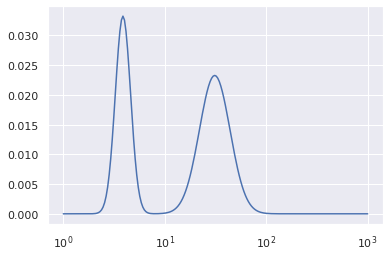

In [4]:
def exp_T(n, Tmin, Tmax, N):
    return Tmin * np.exp(- (n - 1) * np.log( Tmin / Tmax ) / (N - 1)) 

def reg_T(m, tmin, tmax, M):
    return tmin + (tmax - tmin) * (m-1)/ (M - 1) 

N = 200
n = np.arange(N)+1
T_n_exp = exp_T(n, 1, 1000, N)

fg, ax  = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x)

M = 50
m = np.arange(M)+1
T_n_reg = reg_T(m, 0, 1.5, M)

K = np.exp(-T_n_reg.reshape(-1,1) @ T_n_exp.reshape(-1,1).T)
print(K.shape)

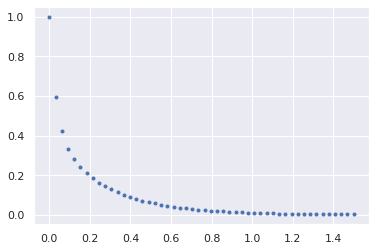

In [5]:
z = K @ x
#sigma_2 = (1e-4 * z  * z.T * np.eye(M))
sigma_2 = np.square(1e-2 * z[0]) * np.eye(M)
w = np.random.normal(loc = 0, scale=np.diag(sigma_2))
y = z.reshape(-1,) + w

fg, ax  = plt.subplots(1,1)
ax.plot(T_n_reg, y, linestyle='',marker='.')

# Comparison of regularization strategies

## Smoothness prior

### Question 1 : Existence and uniqueness of the solution to the problem
Let's  $$ f(x) = \frac{1}{2} \vert \vert Kx - y \vert\vert ^ 2 + \beta \vert\vert D x \vert\vert^2 $$ 
We have the following hessian matrix for $f$ : 
$$ \nabla ^2 f = K^TK + \beta D^TD $$
which is a positive definite matrix and therefore f is stricly convex. It is clearly l.s.c  (being continuous) and coercive. 

Thus it exists a unique solution to the problem of minimizing f. 

### Question 2 : Approach to solve problem 
We can compute the gradient of $f$ and have a closed-form expression for its zero. 
$$ \nabla f (x) = K^T K x - K^T y + \beta D^T D x $$
$$ \nabla f (x) = 0 \Leftrightarrow x = (K^T K + \beta D^T D)^{-1} K^T y $$ 
From question 1, we are sure that the zero of the gradient is the solution to the minization problem

In [6]:
D = np.eye(N)
for index in range(N):
    D[index,index-1] = -1

Text(0.5, 1.0, 'Reconstruction result, Smoothness prior, beta=0.08, normalized_error=16.086976174920153')

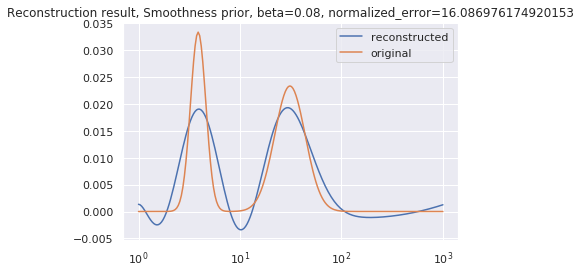

In [7]:
def smoothness_prior(beta):
    return np.linalg.inv(K.T @ K + beta*(D.T @ D)) @ K.T @ y

betas = [8e-2]#[10**(-k/4) for k in range(1,32)]
best_error = np.inf
for beta in betas:
    x_rec = smoothness_prior(beta)
    std_error = np.linalg.norm(x-x_rec)/np.linalg.norm(x)
    if std_error < best_error:
        best_error = std_error
        best_beta = beta
        best_x_rec = x_rec
    
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, best_x_rec, label='reconstructed')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Smoothness prior, beta={0}, normalized_error={1}'.format(best_beta, best_error))

## Smoothness prior + constraints

### Question 1 
The addition of constraints does not impact the strict convexity or the l.s.c property of the funciton. In our case the constraint does not impact the coercivity. Therefore it exists a unique minimizer to f when the constraint is added

Thus it exists a unique solution to the problem of minimizing f. 

### Question 2 

The previous approach is not suitable with the addition of the $\iota_{ [ x_{min}, x_{max}] }$ term. 
We will use the forward-backward algorithm which, in our case, ends up being the projected gradient version. 

We consider the minimization of $ f+g $ with $$ f(x) = \frac{1}{2} \vert \vert Kx - y \vert\vert ^ 2 + \beta \vert\vert D x \vert\vert^2 $$ 
and 
$$ g(x) = \iota_{ [ x_{min}, x_{max}] }(x) $$  

As previously we have : 
$$ \nabla f (x) = K^T K x - K^T y + \beta D^T D x $$ 

Therefore $f$ has a Lipschitz gradient with a Lipschitz constant  $max(specter(K^T K + \beta D^TD)$  
As the other hypothesis are verified, the algortihm converges to a minimizer of $f$ in $[x_{min}, x_{max}]$ 

It took 10 iterations to converge.


Text(0.5, 1.0, 'Reconstruction result, Projected Gradient, beta=0.01, normalized_error=3.4977672413211986e-07')

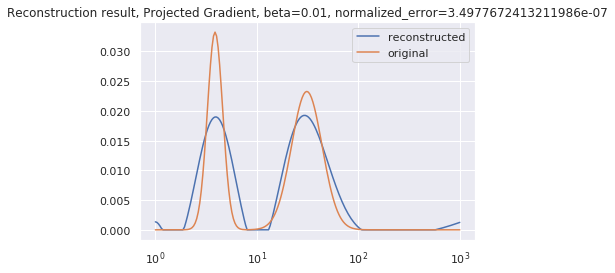

In [8]:
# choose beta
beta = 1e-2
nu = np.max(abs(np.linalg.eigvals(K.T @ K + beta * D.T @ D)))
# choose gamma in ]0, 2/nu[
gamma = 1/nu
delta = 2 - gamma*nu/2
# choose lbda in [0, delta[
lbda = delta/2#

assert gamma > 0 and gamma < 2/nu
assert lbda >=0 and lbda < delta

def proj_grad(gamma, lbda, max_iter=1000):
    itr = 0
    x_min = np.min(x)
    x_max = np.max(x)
    x_n = best_x_rec #np.random.rand(x.shape[0],x.shape[1])
    convergence = False
    while itr < max_iter and not convergence:
        w_n = x_n - gamma * beta * D.T @ D @ x_n
        x_n1 = x_n + lbda * (np.clip(w_n, a_min=x_min, a_max=x_max) - x_n)
        error = np.linalg.norm(x_n1-x_n)/np.linalg.norm(x_n)
        convergence = error <= 1e-6
        x_n = x_n1
        itr+=1
    
    print('It took {} iterations to converge.'.format(itr))
        
    return x_n, error

x_rec, error = proj_grad(gamma, lbda, max_iter=1000)
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x_rec, label='reconstructed')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Projected Gradient, beta={0}, normalized_error={1}'.format(beta, error))

### Sparsity prior : proximal point algorithm

### Question 1 

# TO DO 

### Question 2 


We consider the minimization of $ f+g $ with $$ f(x) = \frac{1}{2} \vert \vert Kx - y \vert\vert ^ 2 $$ 
and 
$$ g(x) = \beta \vert\vert x \vert\vert_1  $$  
We will use the forward-backward algorithm. 

As previously we have :  $f$ with a Lipschitz gradient with a Lipschitz constant  $max(specter(K^T K)$  
and $g \in \Gamma_0(\mathbb{R}^n)$ 
As the other hypothesis are verified, the algortihm converges to a minimizer of $f$ in $[x_{min}, x_{max}]$ 
We also have prox f = EXPRESSION PROX NORME L1 

POUR FORWARD BACKWARD CF PART 2 ET REMPLACER LE PROX

In [9]:
def proximal_point():
    gamma_n = 

SyntaxError: invalid syntax (<ipython-input-9-e3d120df5fac>, line 2)